## Data Cleanup and Manipulation
### Tohoku-Oki Earthquake - March 11, 2011

Article: https://www.nature.com/articles/ncomms13349

Website the data was on: https://www.eas.slu.edu/GGP/tohoku2011.html

Data used here is data recorded by a superconducting gravimeter in the underground Kamioka Observatory during the 2011 Mw 9.0 Tohoku-Oki earthquake in Kamioka, Japan. Latitude and Longitude are included in the file. Gravity is measured in (uGal) and pressure is measured in (hPa/V). One gal equals a change in rate of motion of one centimetre (0.3937 inch). 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read in the data file
df = pd.read_table('ka110300.ggs', skiprows=list(range(0, 19)) + [20])

# Splitting the big column ['yyyymmdd hhmmss gravity(V) pressure(hPa)'] into new columns
df[['Date', 'Time', 'Gravity(V)', 'Pressure(hPa)']] = df['yyyymmdd hhmmss gravity(V) pressure(hPa)'].str.split(expand=True)

# Drop the old column
df.drop(columns=['yyyymmdd hhmmss gravity(V) pressure(hPa)'], inplace=True)

# Drop any values that are 'None' or blank
df = df.dropna()

In [27]:
# Define the conversion factor
# 1 volt (V) = 10^6 microvolts (µV)
# 1 microgal (µGal) = 10^-8 meters per second squared (m/s²)
conversion_factor = 10**6 * 10**-8

# Convert the 'Gravity(V)' column to numeric
df['Gravity(V)'] = pd.to_numeric(df['Gravity(V)'], errors='coerce')

# Now, let's perform the conversion for each row in the "Gravity(V)" column
# We'll use the derivative approximation for the conversion

# Define a function to calculate the microgals
def convert_to_microgals(dV_dr):
    return -dV_dr * conversion_factor

# Assuming your "Gravity(V)" column is named 'Gravity(V)'
# Calculate the change in gravitational potential with respect to distance
# For simplicity, we'll approximate it as the difference between consecutive values
# You may need to adjust this if you have a more precise way to calculate it
dV_dr = df['Gravity(V)'].diff()

# Apply the conversion function to each value in the 'Gravity(V)' column
df['Gravity(µGal)'] = dV_dr.apply(convert_to_microgals)

# Drop any values that are 'None' or blank
df = df.dropna()

In [28]:
df

,Date,Time,Gravity(V),Pressure(hPa),Gravity(µGal)
1,20110301,000000,0.527852,968.549,-0.005279
2,20110301,000001,0.529700,968.547,-0.000018
3,20110301,000002,0.521487,968.547,0.000082
4,20110301,000003,0.507439,968.549,0.000140
5,20110301,000004,0.495192,968.552,0.000122
...,...,...,...,...,...
2678396,20110331,235955,0.327207,981.341,-0.000001
2678397,20110331,235956,0.325348,981.341,0.000019
2678398,20110331,235957,0.323443,981.334,0.000019
2678399,20110331,235958,0.322945,981.336,0.000005


## Visualizations

C:\Users\bianc\AppData\Local\Temp\ipykernel_9188\1585288335.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.xticks(pd.date_range(start='2011-03-09', end='2011-03-12', freq='12H'), rotation=45)


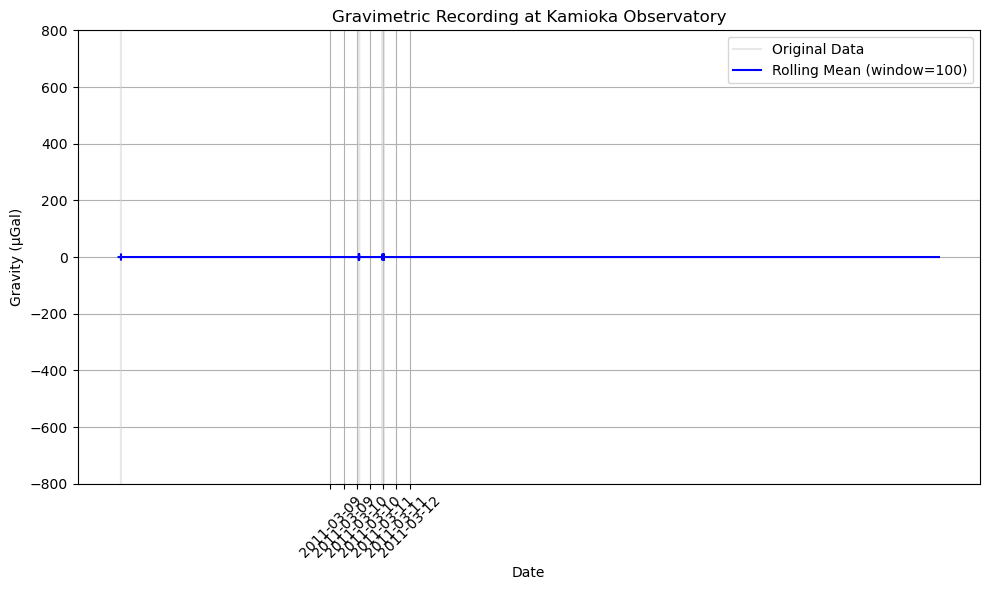

In [29]:
# Convert 'Date' and 'Time' columns to datetime format
df['DateTime'] = pd.to_datetime(df['Date'].astype(str) + df['Time'].astype(str), format='%Y%m%d%H%M%S')

# Set the index to the DateTime column
df.set_index('DateTime', inplace=True)

# Calculate the rolling mean of 'Gravity(µGal)' over a specified window size (e.g., 100 data points)
rolling_mean = df['Gravity(µGal)'].rolling(window=100).mean()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Gravity(µGal)'], color='lightgray', label='Original Data', alpha=0.5)
plt.plot(rolling_mean.index, rolling_mean, color='blue', label='Rolling Mean (window=100)')
plt.xlabel('Date')
plt.ylabel('Gravity (µGal)')
plt.title('Gravimetric Recording at Kamioka Observatory')
plt.ylim(-800, 800)
plt.yticks(range(-800, 801, 200))
plt.xticks(pd.date_range(start='2011-03-09', end='2011-03-12', freq='12H'), rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# Create a range of seconds from 0 to the length of the 'Gravity' column
seconds = range(len(df['Gravity(uGal)']))

# Create a DataFrame with the seconds
seconds_df = pd.DataFrame(seconds, columns=['Seconds'])

# Display the DataFrame
print(seconds_df)

         Seconds
0              0
1              1
2              2
3              3
4              4
...          ...
2676558  2676558
2676559  2676559
2676560  2676560
2676561  2676561
2676562  2676562

[2676563 rows x 1 columns]


           Seconds Gravity(uGal)
0              0.0           0.0
1              1.0      0.527852
2              2.0      0.529700
3              3.0      0.521487
4              4.0      0.507439
...            ...           ...
2676558  2676558.0      0.015402
2676559  2676559.0      0.017180
2676560  2676560.0      0.023807
2676561  2676561.0      0.031039
2676562  2676562.0      0.035318

[2674725 rows x 2 columns]
           Seconds Gravity(uGal)
0              0.0           0.0
100          100.0      0.510628
200          200.0      0.529757
300          300.0      0.528473
400          400.0      0.541184
...            ...           ...
2676138  2676138.0     -0.047538
2676238  2676238.0     -0.028749
2676338  2676338.0     -0.011725
2676438  2676438.0      0.005833
2676538  2676538.0      0.027135

[26748 rows x 2 columns]


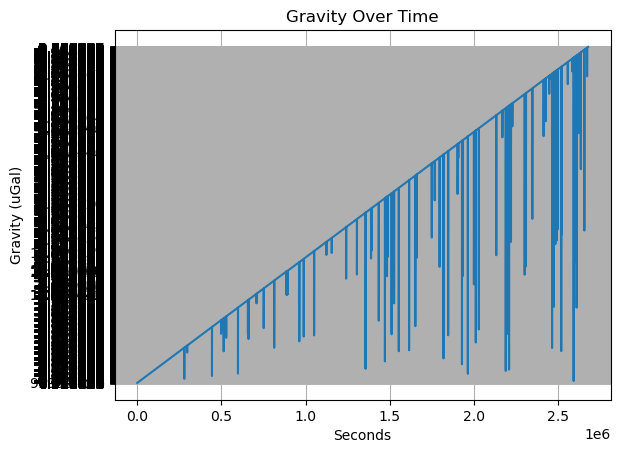

In [9]:
# Merge seconds DataFrame with 'Gravity' column
merged_df = pd.concat([seconds_df, df['Gravity(uGal)']], axis=1)

merged_df = merged_df.dropna()

print(merged_df)

# Downsample the data
downsampled_df = merged_df[::100]  # Take every 100th row

print(downsampled_df)

# Plot 'Gravity' against seconds
plt.plot(downsampled_df['Seconds'], downsampled_df['Gravity(uGal)'])
plt.title('Gravity Over Time')
plt.xlabel('Seconds')
plt.ylabel('Gravity (uGal)')
plt.grid(True)
plt.show()

C:\Users\bianc\AppData\Local\Temp\ipykernel_9188\1837789909.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['DateTime'] = pd.to_datetime(filtered_df['Date'].astype(str) + filtered_df['Time'].astype(str), format='%Y%m%d%H%M%S')
C:\Users\bianc\AppData\Local\Temp\ipykernel_9188\1837789909.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.xticks(pd.date_range(start=filtered_df['DateTime'].min(), end=filtered_df['DateTime'].max(), freq='12H'), rotation=45, ha='right')


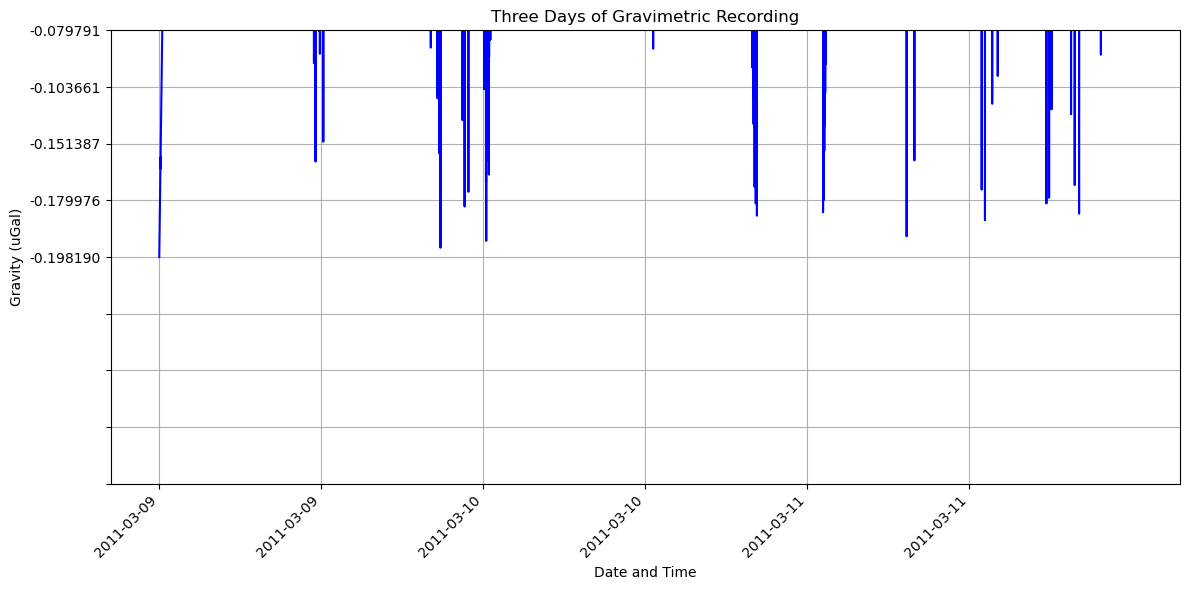

In [13]:
# Convert start and end dates to integers
start_date = 20110309
end_date = 20110312

# Convert 'Date' column to integers
df['Date'] = df['Date'].astype(int)

# Filter the DataFrame to include only data for the specified time range
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] < end_date)]

# Convert 'Date' and 'Time' columns to datetime
filtered_df['DateTime'] = pd.to_datetime(filtered_df['Date'].astype(str) + filtered_df['Time'].astype(str), format='%Y%m%d%H%M%S')

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['DateTime'], filtered_df['Gravity(uGal)'], color='blue')
plt.title('Three Days of Gravimetric Recording')
plt.xlabel('Date and Time')
plt.ylabel('Gravity (uGal)')
plt.ylim(-800, 800)
plt.yticks(range(-800, 801, 200))
plt.xticks(pd.date_range(start=filtered_df['DateTime'].min(), end=filtered_df['DateTime'].max(), freq='12H'), rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()